In [1]:
import pandas as pd
import json
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer, SimpleImputer
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

c:\Projekts\mondy-markers\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
RANDOM_STATE = 42

In [3]:
def months_since_start(group):
    start_date = group["timestamp_utc"].min()
    return (group["timestamp_utc"].dt.year - start_date.year) * 12 + (
        group["timestamp_utc"].dt.month - start_date.month
    )

In [4]:
df_raw = pd.read_pickle("data/df_merged_v3.pickle")

# Map IDs to pseudonyms
json_file_path = "config/id_to_pseudonym.json"
with open(json_file_path, "r", encoding="utf-8") as f:
    id_to_pseudonym = json.load(f)

df_raw["pseudonym"] = df_raw["patient_id"].map(id_to_pseudonym)
df_raw = df_raw.dropna(subset=["pseudonym"])
df_raw = df_raw.drop(columns=["patient_id"])
df_raw["day_of_week"] = df_raw["timestamp_utc"].dt.weekday
df_raw["month_of_year"] = df_raw["timestamp_utc"].dt.month
df_raw["month_since_start"] = df_raw.groupby("pseudonym", group_keys=False).apply(
    months_since_start
)

target_column = "abend_PHQ2_sum"
pseudonyms = df_raw["pseudonym"].unique()

In [38]:
os.makedirs("profiles", exist_ok=True)

for pseudonym in pseudonyms:
    df_participant = df_raw[df_raw["pseudonym"] == pseudonym].iloc[:365]
    constant_value_columns = list(df_participant.loc[:, ~(df_participant.nunique() > 1)].columns)
    print(f"{pseudonym} - Dropping constant columns: {constant_value_columns}")
    df_participant = df_participant.loc[:, df_participant.nunique() > 1]
    timeseries_columns = list(df_participant.columns)
    timeseries_columns.remove("timestamp_utc")
    type_schema = {col: "timeseries" for col in timeseries_columns}
    profile = ProfileReport(df_participant, title=f"Data Profile of {pseudonym}", explorative=True, interactions={"targets": [target_column, "woche_PHQ9_sum"]}, tsmode=True, type_schema=type_schema, sortby="timestamp_utc", vars={"num": {"low_variance_threshold": 0.0}})
    profile.to_file(f"profiles/{pseudonym}_data_profile.html")

pleasedsardines7 - Dropping constant columns: ['total_sm_rx', 'total_sm_tx', 'total_sm_app_usage', 'pseudonym']


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 37/37 [00:00<00:00, 43.46it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
pseudonyms

array(['bubblypie2', 'euphoricpanda1', 'sugarysmelt2', 'artisticleopard7',
       'yearningwasp7', 'worldlylion3', 'humorousflamingo5',
       'curiousdoves7', 'cheerfulsnipe5', 'kinddinosaur0',
       'flowerdchild3', 'artisticrhino0', 'pleasedsardines7',
       'humoroushare2', 'frozenpuffin9'], dtype=object)

In [6]:
df_participant = df_raw[df_raw["pseudonym"] == "cheerfulsnipe5"].iloc[:365]

In [7]:
df = df_participant.drop(columns=["pseudonym", "timestamp_utc", "woche_PHQ9_sum"])
df = df.astype(float)
# df = df.dropna()
y = df[target_column].values
X = df.drop(columns=[target_column])

In [8]:
X.shape, y.shape

((365, 36), (365,))

In [9]:
pre_pipeline = Pipeline(
        [
            (
                "imputer",
                IterativeImputer(
                    max_iter=20,
                    random_state=RANDOM_STATE,
                    # estimator=HistGradientBoostingRegressor(random_state=RANDOM_STATE),
                ),
                # KNNImputer(),
            ),
            ("scaler", MinMaxScaler()),
        ])

In [10]:
X_preproc = pre_pipeline.fit_transform(X)
X_preproc.shape

(365, 36)

In [11]:
target_mask = df_participant[target_column].notna()
df_model = df.loc[target_mask]
X_model = X_preproc[target_mask]
y_model = y[target_mask]

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
            X_model,
            y_model,
            test_size=0.3,
            shuffle=True,
            random_state=42,
        )

In [13]:
elastic = ElasticNetCV(cv=5, 
                       # l1_ratio=0.5,
                       random_state=RANDOM_STATE,
                       #verbose=2
                       )
elastic.fit(X_train, y_train)
y_pred_elastic = elastic.predict(X_test)
r2_elastic = round(r2_score(y_test, y_pred_elastic), 3)
mae_elastic = round(mean_absolute_error(y_test, y_pred_elastic), 3)
r2_elastic, mae_elastic

(0.067, 2.497)

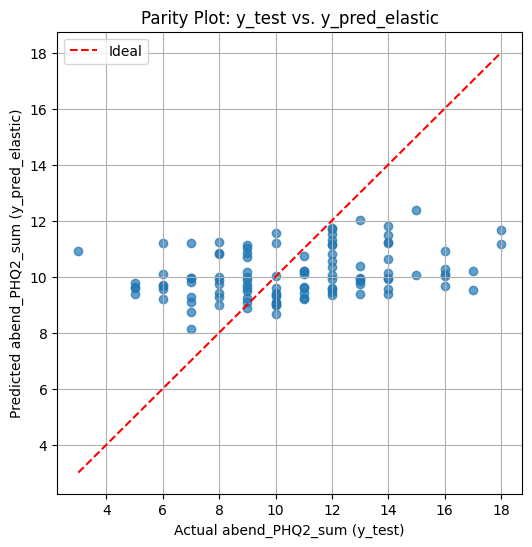

In [14]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_elastic, alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label='Ideal')
plt.xlabel('Actual abend_PHQ2_sum (y_test)')
plt.ylabel('Predicted abend_PHQ2_sum (y_pred_elastic)')
plt.title('Parity Plot: y_test vs. y_pred_elastic')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
from pycaret.regression import *
import pandas as pd
from sklearn.metrics import mean_absolute_error, r2_score

# Setup PyCaret
reg_setup = setup(
    data=df_model,
    target=target_column,
    session_id=123,
    train_size=0.7,
    normalize=True,
    verbose=False
)

# Compare and select best model
best_model = compare_models(include=["lr", "en", "lasso", "ridge"])

# Finalize model on full training set
final_model = finalize_model(best_model)

# Predict on test set
predictions = predict_model(final_model)

# Extract y_true and y_pred
y_true = predictions[target_column]
y_pred = predictions['prediction_label']

# Calculate metrics
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

# Print metrics
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
en,Elastic Net,2.5703,10.8219,3.2371,-0.0092,0.3148,0.3230,0.3540
lasso,Lasso Regression,2.6477,11.3403,3.3199,-0.0642,0.3211,0.3302,0.0120
ridge,Ridge Regression,2.6709,12.8429,3.4768,-0.2322,0.3388,0.3302,0.0150
lr,Linear Regression,2.6874,12.8787,3.4859,-0.2378,0.3465,0.3325,0.5920


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,2.5950,10.0574,3.1713,0.0596,0.3005,0.2994


MAE: 2.5950
R²: 0.0596


In [16]:
predictions.shape

(105, 38)

In [17]:
df_model.shape

(347, 37)

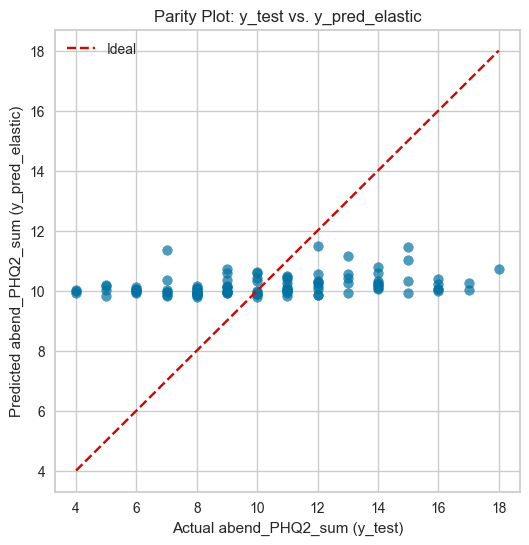

In [18]:
plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, alpha=0.7)
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--', label='Ideal')
plt.xlabel('Actual abend_PHQ2_sum (y_test)')
plt.ylabel('Predicted abend_PHQ2_sum (y_pred_elastic)')
plt.title('Parity Plot: y_test vs. y_pred_elastic')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
from pycaret.regression import *
import pandas as pd
from sklearn.metrics import mean_absolute_error, r2_score

# Setup PyCaret
reg_setup = setup(
    data=df_model,
    target=target_column,
    session_id=123,
    train_size=0.7,
    normalize=True,
    verbose=False
)

# Compare and select best model
best_model = compare_models(include=["en", "rf"])

# Finalize model on full training set
# final_model = finalize_model(best_model)

# Predict on test set
predictions = predict_model(best_model)

# Extract y_true and y_pred
y_true = predictions[target_column]
y_pred = predictions['prediction_label']

# Calculate metrics
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

# Print metrics
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,2.4478,9.7615,3.0827,0.0709,0.3032,0.3096,0.0550
en,Elastic Net,2.5703,10.8219,3.2371,-0.0092,0.3148,0.3230,0.0120


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,2.5496,10.0733,3.1738,0.0581,0.2996,0.2933


MAE: 2.5496
R²: 0.0581


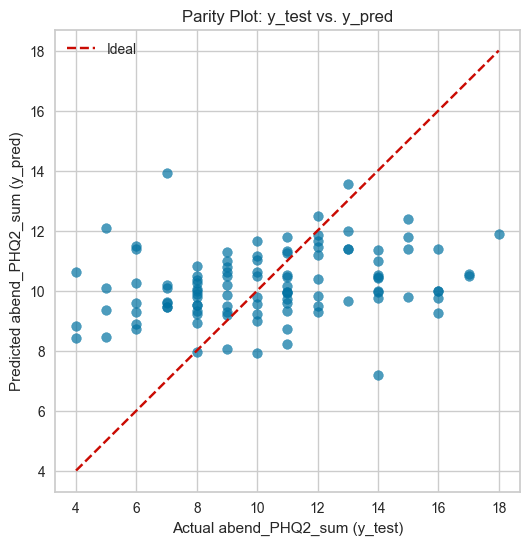

In [20]:
plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, alpha=0.7)
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--', label='Ideal')
plt.xlabel('Actual abend_PHQ2_sum (y_test)')
plt.ylabel('Predicted abend_PHQ2_sum (y_pred)')
plt.title('Parity Plot: y_test vs. y_pred')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
best_model

RandomForestRegressor(n_jobs=-1, random_state=123)

In [22]:
print(best_model.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False}


In [23]:
final_model

Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['total_duration_calls',
                                             'number_of_contacts',
                                             'total_calling_frequency',
                                             'nbr_missed_calls',
                                             'loudness_sma3_amean',
                                             'loudness_sma3_stddevNorm',
                                             'F0semitoneFrom27.5Hz_sma3nz_amean',
                                             'F0semitoneFrom27.5Hz_sma3nz_stddevNorm',
                                             'jitterLocal_sma3nz_amean',
                                             'shimmerLocald...
                                             'HRV_HF_rq1_day',
                                             'HRV_LFHF_rq1_day', ...],
                                    transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransformerWrapper(include=[],
                                    transformer=SimpleImputer(strategy='most_frequent'))),
                ('normalize', TransformerWrapper(transformer=StandardScaler())),
                ('clean_column_names',
                 TransformerWrapper(transformer=CleanColumnNames())),
                ('actual_estimator', ElasticNet(random_state=123))])

In [24]:
from pycaret.regression import *
import pandas as pd
from sklearn.metrics import mean_absolute_error, r2_score

# Setup PyCaret
reg_setup = setup(
    data=df_model,
    target=target_column,
    session_id=123,
    train_size=0.7,
    normalize=True,
    verbose=False
)

# Compare and select best model
best_model = compare_models()

# Finalize model on full training set
# final_model = finalize_model(best_model)

# Predict on test set
predictions = predict_model(best_model)

# Extract y_true and y_pred
y_true = predictions[target_column]
y_pred = predictions['prediction_label']

# Calculate metrics
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

# Print metrics
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,2.4478,9.7615,3.0827,0.0709,0.3032,0.3096,0.0510
ada,AdaBoost Regressor,2.4511,9.8782,3.1040,0.0577,0.3048,0.3071,0.0230
lightgbm,Light Gradient Boosting Machine,2.5303,10.2697,3.1578,0.0115,0.3083,0.3124,0.0790
et,Extra Trees Regressor,2.4704,10.3621,3.1757,0.0075,0.3084,0.3096,0.0310
omp,Orthogonal Matching Pursuit,2.5099,10.6569,3.1983,0.0043,0.3100,0.3146,0.0110
en,Elastic Net,2.5703,10.8219,3.2371,-0.0092,0.3148,0.3230,0.0080
gbr,Gradient Boosting Regressor,2.5203,10.3055,3.1749,-0.0099,0.3146,0.3195,0.0430
xgboost,Extreme Gradient Boosting,2.5699,10.8231,3.2500,-0.0397,0.3167,0.3206,0.3550
knn,K Neighbors Regressor,2.5768,10.8604,3.2512,-0.0462,0.3135,0.3187,0.0270
dummy,Dummy Regressor,2.6480,11.3315,3.3183,-0.0631,0.3210,0.3301,0.0100


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,2.5496,10.0733,3.1738,0.0581,0.2996,0.2933


MAE: 2.5496
R²: 0.0581


In [25]:
target_mask = df_participant[target_column].notna()
df_model = df.loc[target_mask]
X_model = X[target_mask]
y_model = y[target_mask]
X_model.shape, y_model.shape

((347, 36), (347,))

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
            X_model,
            y_model,
            test_size=0.3,
            shuffle=True,
            random_state=42,
        )

In [27]:
params = {
    'bootstrap': True,
    'ccp_alpha': 0.0,
    'criterion': 'squared_error',
    'max_depth': None,
    'max_features': 1.0,
    'max_leaf_nodes': None,
    'max_samples': None,
    'min_impurity_decrease': 0.0,
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'min_weight_fraction_leaf': 0.0,
    'monotonic_cst': None,  # Note: This is NOT a valid parameter for RandomForestRegressor
    'n_estimators': 100,
    'n_jobs': -1,
    'oob_score': False,
    'random_state': 123,
    'verbose': 0,
    'warm_start': False
}

# Remove invalid key for sklearn (monotonic_cst is not supported)
# params.pop('monotonic_cst')

In [28]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
import numpy as np
import re


# Preprocessing for each type
preprocessor = ColumnTransformer([
    ('imputer', SimpleImputer(), X_train.columns),
])

# Full pipeline
pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('scaling', StandardScaler()),  # Will scale all features after imputation
    ('model', RandomForestRegressor(**params))
])


In [29]:
pipeline.fit(get_config("X_train"), get_config("y_train"))

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('imputer', SimpleImputer(),
                                                  Index(['total_duration_calls', 'number_of_contacts', 'total_calling_frequency',
       'nbr_missed_calls', 'loudness_sma3_amean', 'loudness_sma3_stddevNorm',
       'F0semitoneFrom27.5Hz_sma3nz_amean',
       'F0semitoneFrom27.5Hz_sma3nz_stddevNorm', 'jitterLocal_sma3nz_amean',
       'shimmerL...
       'HRV_MadNN_rq1_day', 'HRV_SDRMSSD_rq1_day', 'HRV_MinNN_rq1_day',
       'HRV_ULF_rq1_day', 'HRV_HF_rq1_day', 'HRV_LFHF_rq1_day',
       'number_used_ibi_datapoints_rq1_day', 'total_activity_min',
       'daily_sleep_duration', 'nightly_sleep_duration', 'day_of_week',
       'month_of_year'],
      dtype='object'))])),
                ('scaling', StandardScaler()),
                ('model', RandomForestRegressor(n_jobs=-1, random_state=123))])

In [30]:
get_config("X_test")

,total_duration_calls,number_of_contacts,total_calling_frequency,nbr_missed_calls,loudness_sma3_amean,loudness_sma3_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,jitterLocal_sma3nz_amean,shimmerLocaldB_sma3nz_amean,...,HRV_MinNN_rq1_day,HRV_ULF_rq1_day,HRV_HF_rq1_day,HRV_LFHF_rq1_day,number_used_ibi_datapoints_rq1_day,total_activity_min,daily_sleep_duration,nightly_sleep_duration,day_of_week,month_of_year
3620,0.0,0.0,0.0,0.0,0.330072,0.607401,21.324247,0.254484,0.021729,0.967002,...,200.0,0.000837,0.008317,0.656108,28471.0,420.0,0.533344,3.985255,2.0,8.0
3416,0.0,0.0,0.0,1.0,0.184206,0.579397,19.314837,0.117558,0.023885,1.151758,...,280.0,0.001176,0.001101,1.358514,5538.0,444.0,0.000000,5.060911,1.0,1.0
3389,1291.0,6.0,7.0,0.0,0.223092,0.522184,19.496180,0.113036,0.022758,1.102496,...,40.0,0.000680,0.005130,0.448001,22880.0,337.0,0.000000,0.533656,2.0,12.0
3372,0.0,0.0,0.0,0.0,0.231238,0.588241,19.638241,0.117760,0.024762,1.209405,...,40.0,0.000793,0.005610,0.484957,17491.0,349.0,0.000000,0.233511,6.0,12.0
3560,58.0,1.0,1.0,0.0,0.243948,0.678381,19.917553,0.196567,0.023693,1.149433,...,160.0,0.000866,0.006644,0.777837,17343.0,328.0,0.000000,5.086933,5.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3379,0.0,0.0,0.0,0.0,0.261675,0.634730,21.539927,0.174396,0.023380,0.998538,...,40.0,0.000235,0.004607,0.536111,23006.0,334.0,0.000000,0.725044,6.0,12.0
3589,0.0,0.0,0.0,0.0,0.332291,0.765455,20.466358,0.174292,0.022374,1.225716,...,240.0,0.000585,0.002755,0.731084,21444.0,359.0,0.058400,2.733022,6.0,7.0
3376,294.0,1.0,1.0,0.0,0.275584,0.582814,20.823927,0.120902,0.023435,1.122496,...,40.0,0.000697,0.009524,0.538558,20909.0,255.0,0.000000,0.000000,3.0,12.0
3573,0.0,0.0,0.0,0.0,0.456456,0.653715,22.098438,0.165549,0.024187,1.129130,...,240.0,0.000997,0.007635,0.732413,15231.0,NaN,0.000000,2.733178,4.0,6.0


In [31]:
predictions = pipeline.predict(get_config("X_test"))
r2_rf = round(r2_score(get_config("y_test"), predictions), 3)
mae_rf = round(mean_absolute_error(get_config("y_test"), predictions), 3)
r2_rf, mae_rf

(0.058, 2.55)

In [32]:
rf = RandomForestRegressor(random_state=RANDOM_STATE)
cv_params = {
    "max_depth": [4, 5, 6, 7, 8],
    "n_estimators": [75, 100, 125, 150, 175, 200],
    "min_samples_leaf": [2, 4, 6, 8, 10],
}
rf_cv = GridSearchCV(
    rf,
    cv_params,
    # scoring="r2",
    scoring="neg_mean_absolute_error",
    cv=5,
    n_jobs=4,
)
rf_cv.fit(X_train, y_train)

best_rf = rf_cv.best_estimator_
y_pred_rf = best_rf.predict(X_test)
r2_rf = round(r2_score(y_test, y_pred_rf), 3)
mae_rf = round(mean_absolute_error(y_test, y_pred_rf), 3)
r2_rf, mae_rf

(0.073, 2.442)

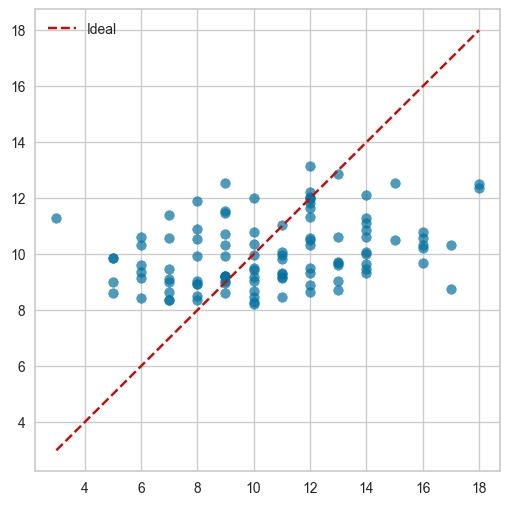

In [33]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label='Ideal')
plt.legend()
plt.grid(True)
plt.show()

In [34]:
from pycaret.regression import *
import pandas as pd
from sklearn.metrics import mean_absolute_error, r2_score

# Setup PyCaret
reg_setup = setup(
    data=df_model,
    target=target_column,
    session_id=123,
    train_size=0.7,
    normalize=True,
    verbose=False,
    # feature_selection=True,
    # primary_metric='R2'
)

# Compare and select best model
best_model = compare_models(include=["en", "rf", "xgboost"])

# Finalize model on full training set
# final_model = finalize_model(best_model)

# Predict on test set
predictions = predict_model(best_model)

# Extract y_true and y_pred
y_true = predictions[target_column]
y_pred = predictions['prediction_label']

# Calculate metrics
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

# Print metrics
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,2.4478,9.7615,3.0827,0.0709,0.3032,0.3096,0.7200
en,Elastic Net,2.5703,10.8219,3.2371,-0.0092,0.3148,0.3230,0.8990
xgboost,Extreme Gradient Boosting,2.5699,10.8231,3.2500,-0.0397,0.3167,0.3206,0.3000


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,2.5496,10.0733,3.1738,0.0581,0.2996,0.2933


MAE: 2.5496
R²: 0.0581


In [35]:
best_model

RandomForestRegressor(n_jobs=-1, random_state=123)

In [36]:
get_config("pipeline")

Pipeline(memory=FastMemory(location=C:\Users\JOHANN~1\AppData\Local\Temp\joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['total_duration_calls',
                                             'number_of_contacts',
                                             'total_calling_frequency',
                                             'nbr_missed_calls',
                                             'loudness_sma3_amean',
                                             'loudness_sma3_stddevNorm',
                                             'F0semitoneFrom27.5Hz_sma3nz_amean',
                                             'F0semitoneFrom27.5Hz_sma3nz_stddevNorm...
                                             'HRV_MinNN_rq1_day',
                                             'HRV_ULF_rq1_day',
                                             'HRV_HF_rq1_day',
                                             'HRV_LFHF_rq1_day', ...],
                                    transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransformerWrapper(include=[],
                                    transformer=SimpleImputer(strategy='most_frequent'))),
                ('normalize', TransformerWrapper(transformer=StandardScaler())),
                ('clean_column_names',
                 TransformerWrapper(transformer=CleanColumnNames()))])

In [60]:
pipeline = Pipeline(
        [
            (
                "imputer",
                IterativeImputer(
                #     max_iter=20,
                #     random_state=RANDOM_STATE,
                #     # estimator=HistGradientBoostingRegressor(random_state=RANDOM_STATE),
                ),
                # SimpleImputer(),
            ),
            ("scaler", RobustScaler()),
        ])

In [61]:
y = df[target_column].values
X = df.drop(columns=[target_column])
indices = np.arange(len(X))
# X = df.drop(columns=[target_column, "total_duration_calls", "number_of_contacts", "total_calling_frequency", "nbr_missed_calls", "total_sm_app_usage", "total_com_app_usage", "daily_sleep_duration", "nightly_sleep_duration", "total_com_rx", "total_com_tx"])
# X = df[["HRV_MeanNN_rq1_day", "HRV_MedianNN_rq1_day", "mfcc2V_sma3nz_amean", "nightly_sleep_duration", "number_used_ibi_datapoints_rq1_day", "steps_sum_rq1_day", "total_activity_min", "total_com_rx",	"total_com_tx", ]]

In [62]:
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, y, 
            indices,
            test_size=0.3,
            shuffle=True,
            random_state=RANDOM_STATE,
        )
X_train.shape, X_test.shape, y_train.shape, y_test.shape, idx_train.shape, idx_test.shape

((255, 36), (110, 36), (255,), (110,), (255,), (110,))

In [63]:
X_train_transformed = pipeline.fit_transform(X_train)

In [64]:
X_test_transformed = pipeline.transform(X_test)

In [65]:
df.reset_index(drop=True, inplace=True)
target_train_mask = df.loc[idx_train, target_column].notna()
target_test_mask = df.loc[idx_test, target_column].notna()
target_train_mask.shape, target_test_mask.shape

((255,), (110,))

In [66]:
X_train = X_train_transformed[target_train_mask]
y_train = y_train[target_train_mask]
X_test = X_test_transformed[target_test_mask]
y_test = y_test[target_test_mask]

In [67]:
elastic = ElasticNetCV(cv=5, 
                       l1_ratio=0.5,
                       random_state=RANDOM_STATE,
                       #verbose=2
                       )
elastic.fit(X_train, y_train)
y_pred_elastic = elastic.predict(X_test)
r2_elastic = round(r2_score(y_test, y_pred_elastic), 3)
mae_elastic = round(mean_absolute_error(y_test, y_pred_elastic), 3)
r2_elastic, mae_elastic

(-1.379, 3.176)

In [68]:
rf = RandomForestRegressor(random_state=RANDOM_STATE)
cv_params = {
    "max_depth": [1,2,3,4, 5, 6, 7, 8],
    "n_estimators": [32, 64, 128, 256],
    "min_samples_leaf": [1, 2, 4, 8],
}
rf_cv = GridSearchCV(
    rf,
    cv_params,
    # scoring="r2",
    scoring="neg_mean_absolute_error",
    cv=5,
    n_jobs=4,
)
rf_cv.fit(X_train, y_train)

best_rf = rf_cv.best_estimator_
y_pred_rf = best_rf.predict(X_test)
r2_rf = round(r2_score(y_test, y_pred_rf), 3)
mae_rf = round(mean_absolute_error(y_test, y_pred_rf), 3)
r2_rf, mae_rf

(0.093, 2.785)

In [69]:
y = df[target_column].values
X = df.drop(columns=[target_column])
indices = np.arange(len(X))
# X = df.drop(columns=[target_column, "total_duration_calls", "number_of_contacts", "total_calling_frequency", "nbr_missed_calls", "total_sm_app_usage", "total_com_app_usage", "daily_sleep_duration", "nightly_sleep_duration", "total_com_rx", "total_com_tx"])
# X = df[["HRV_MeanNN_rq1_day", "HRV_MedianNN_rq1_day", "mfcc2V_sma3nz_amean", "nightly_sleep_duration", "number_used_ibi_datapoints_rq1_day", "steps_sum_rq1_day", "total_activity_min", "total_com_rx",	"total_com_tx", ]]

In [70]:
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, y, 
            indices,
            test_size=0.3,
            shuffle=True,
            random_state=RANDOM_STATE,
        )
X_train.shape, X_test.shape, y_train.shape, y_test.shape, idx_train.shape, idx_test.shape

((255, 36), (110, 36), (255,), (110,), (255,), (110,))

In [71]:
X_train_transformed = pipeline.fit_transform(X_train)

In [72]:
X_test_transformed = pipeline.transform(X_test)

In [73]:
df.reset_index(drop=True, inplace=True)
target_train_mask = df.loc[idx_train, target_column].notna()
target_test_mask = df.loc[idx_test, target_column].notna()
target_train_mask.shape, target_test_mask.shape

((255,), (110,))

In [74]:
X_train = X_train_transformed[target_train_mask]
y_train = y_train[target_train_mask]
X_test = X_test_transformed[target_test_mask]
y_test = y_test[target_test_mask]

In [75]:
from sklearn.ensemble import IsolationForest
iso = IsolationForest(contamination=0.05, random_state=42)  # 10% of data considered outliers
outlier_flags = iso.fit_predict(X_train)

In [76]:
np.unique(outlier_flags, return_counts=True)

(array([-1,  1]), array([ 13, 229], dtype=int64))

In [77]:
X_train = X_train[outlier_flags == 1]
y_train = y_train[outlier_flags == 1]

In [78]:
elastic = ElasticNetCV(cv=5, 
                       l1_ratio=0.5,
                       random_state=RANDOM_STATE,
                       #verbose=2
                       )
elastic.fit(X_train, y_train)
y_pred_elastic = elastic.predict(X_test)
r2_elastic = round(r2_score(y_test, y_pred_elastic), 3)
mae_elastic = round(mean_absolute_error(y_test, y_pred_elastic), 3)
r2_elastic, mae_elastic

(-0.983, 3.089)

In [79]:
rf = RandomForestRegressor(random_state=RANDOM_STATE)
cv_params = {
    "max_depth": [1,2,3,4, 5, 6, 7, 8],
    "n_estimators": [32, 64, 128, 256],
    "min_samples_leaf": [1, 2, 4, 8],
    "max_features": [0.5, 0.75, 1.0],  # Added max_features parameter
}
rf_cv = GridSearchCV(
    rf,
    cv_params,
    # scoring="r2",
    scoring="neg_mean_absolute_error",
    cv=5,
    n_jobs=4,
)
rf_cv.fit(X_train, y_train)

best_rf = rf_cv.best_estimator_
y_pred_rf = best_rf.predict(X_test)
r2_rf = round(r2_score(y_test, y_pred_rf), 3)
mae_rf = round(mean_absolute_error(y_test, y_pred_rf), 3)
r2_rf, mae_rf

(0.102, 2.776)